# Train 2D CNN

2D Convolution을 기본 구성 요소로 하는 EEG classifier를 학습해보는 노트북.

-----

## 환경 구성

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import glob
import json
import datetime

import matplotlib.pyplot as plt
import pprint
from IPython.display import clear_output
from tqdm.auto import tqdm

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Type, Any, Callable, Union, List, Optional

# custom package
from utils.eeg_dataset import *

In [3]:
# Other settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # cleaner text

plt.style.use('default') 
# ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 
#  'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 
#  'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 
#  'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 
#  'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams["font.family"] = 'NanumGothic' # for Hangul in Windows

In [4]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.')

PyTorch version: 1.9.0
cuda is available.


In [5]:
# Data file path
root_path = r'dataset/02_Curated_Data/'

In [6]:
meta_path = os.path.join(root_path, 'metadata_debug.json')
with open(meta_path, 'r') as json_file:
    metadata = json.load(json_file)

pprint.pprint(metadata[0])

{'age': 78,
 'birth': '1940-06-02',
 'dx1': 'mci_rf',
 'edfname': '00001809_261018',
 'events': [[0, 'Start Recording'],
            [0, 'New Montage - Montage 002'],
            [36396, 'Eyes Open'],
            [72518, 'Eyes Closed'],
            [73862, 'Eyes Open'],
            [75248, 'Eyes Closed'],
            [76728, 'swallowing'],
            [77978, 'Eyes Open'],
            [79406, 'Eyes Closed'],
            [79996, 'Photic On - 3.0 Hz'],
            [80288, 'Eyes Open'],
            [81296, 'Eyes Closed'],
            [82054, 'Photic Off'],
            [84070, 'Photic On - 6.0 Hz'],
            [84488, 'Eyes Open'],
            [85538, 'Eyes Closed'],
            [86086, 'Photic Off'],
            [88144, 'Photic On - 9.0 Hz'],
            [90160, 'Photic Off'],
            [91458, 'Eyes Open'],
            [92218, 'Photic On - 12.0 Hz'],
            [92762, 'Eyes Closed'],
            [94198, 'Photic Off'],
            [94742, 'Eyes Open'],
            [95708, 'Eyes Close

-----

## Data Filtering by Diagnosis

#### Non-Vascular Dementia, Non-Vascular MCI, Normal

In [7]:
diagnosis_filter = [
    # Normal
    {'type': 'Normal',
     'include': ['normal'], 
     'exclude': []},
    # Non-vascular MCI
    {'type': 'Non-vascular MCI',
     'include': ['mci'], 
     'exclude': ['mci_vascular']},
    # Non-vascular dementia
    {'type': 'Non-vascular dementia',
     'include': ['dementia'], 
     'exclude': ['vd']},
]

def generate_class_label(label):
    for c, f in enumerate(diagnosis_filter):
        inc = set(f['include']) & set(label) == set(f['include'])
        # inc = len(set(f['include']) & set(label)) > 0        
        exc = len(set(f['exclude']) & set(label)) == 0
        if  inc and exc:
            return (c, f['type'])
    return (-1, 'The others')

class_label_to_type = [d_f['type'] for d_f in diagnosis_filter]
print('class_label_to_type:', class_label_to_type)

class_label_to_type: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']


In [8]:
splitted_metadata = [[] for i in diagnosis_filter]

for m in metadata:
    c, n = generate_class_label(m['label'])
    if c >= 0:
        m['class_type'] = n
        m['class_label'] = c
        splitted_metadata[c].append(m)
        
for i, split in enumerate(splitted_metadata):
    if len(split) == 0:
        print(f'(Warning) Split group {i} has no data.')
    else:
        print(f'- There are {len(split):} data belonging to {split[0]["class_type"]}')

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia


-----

## Configure the Train, Validation, and Test Splits

#### Split the filtered dataset and shuffle them

In [9]:
# random seed
random.seed(0)

# Train : Val : Test = 8 : 1 : 1
ratio1 = 0.8
ratio2 = 0.1

metadata_train = []
metadata_val = []
metadata_test = []

for split in splitted_metadata:
    random.shuffle(split)
    
    n1 = round(len(split) * ratio1)
    n2 = n1 + round(len(split) * ratio2)

    metadata_train.extend(split[:n1])
    metadata_val.extend(split[n1:n2])
    metadata_test.extend(split[n2:])

random.shuffle(metadata_train)
random.shuffle(metadata_val)
random.shuffle(metadata_test)

print('Train data size\t\t:', len(metadata_train))
print('Validation data size\t:', len(metadata_val))
print('Test data size\t\t:', len(metadata_test))

print('\n', '--- Recheck ---', '\n')
train_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_train:
    train_class_nums[m['class_label']] += 1

val_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_val:
    val_class_nums[m['class_label']] += 1

test_class_nums = np.zeros((len(class_label_to_type)), dtype=np.int32)
for m in metadata_test:
    test_class_nums[m['class_label']] += 1

print('Train data label distribution\t:', train_class_nums, train_class_nums.sum())
print('Val data label distribution\t:', val_class_nums, val_class_nums.sum())
print('Test data label distribution\t:', test_class_nums, test_class_nums.sum())

# random seed
random.seed()

# print([m['serial']  for m in metadata_train[:15]])
# print([m['serial']  for m in metadata_val[:15]])
# print([m['serial']  for m in metadata_test[:15]])

Train data size		: 831
Validation data size	: 104
Test data size		: 104

 --- Recheck --- 

Train data label distribution	: [370 278 183] 831
Val data label distribution	: [46 35 23] 104
Test data label distribution	: [47 34 23] 104


#### Wrap the splitted data using PyTorch Dataset

In [10]:
ages = []
for m in metadata_train:
    ages.append(m['age'])

ages = np.array(ages)
age_mean = np.mean(ages)
age_std = np.std(ages)

print('Age mean and standard deviation:')
print(age_mean, age_std)

Age mean and standard deviation:
69.92779783393502 9.817569889945597


torch.Size([40, 46, 45])

----------------------------------------------------------------------------------------------------

torch.Size([40, 46, 45])

----------------------------------------------------------------------------------------------------

torch.Size([40, 46, 45])

----------------------------------------------------------------------------------------------------



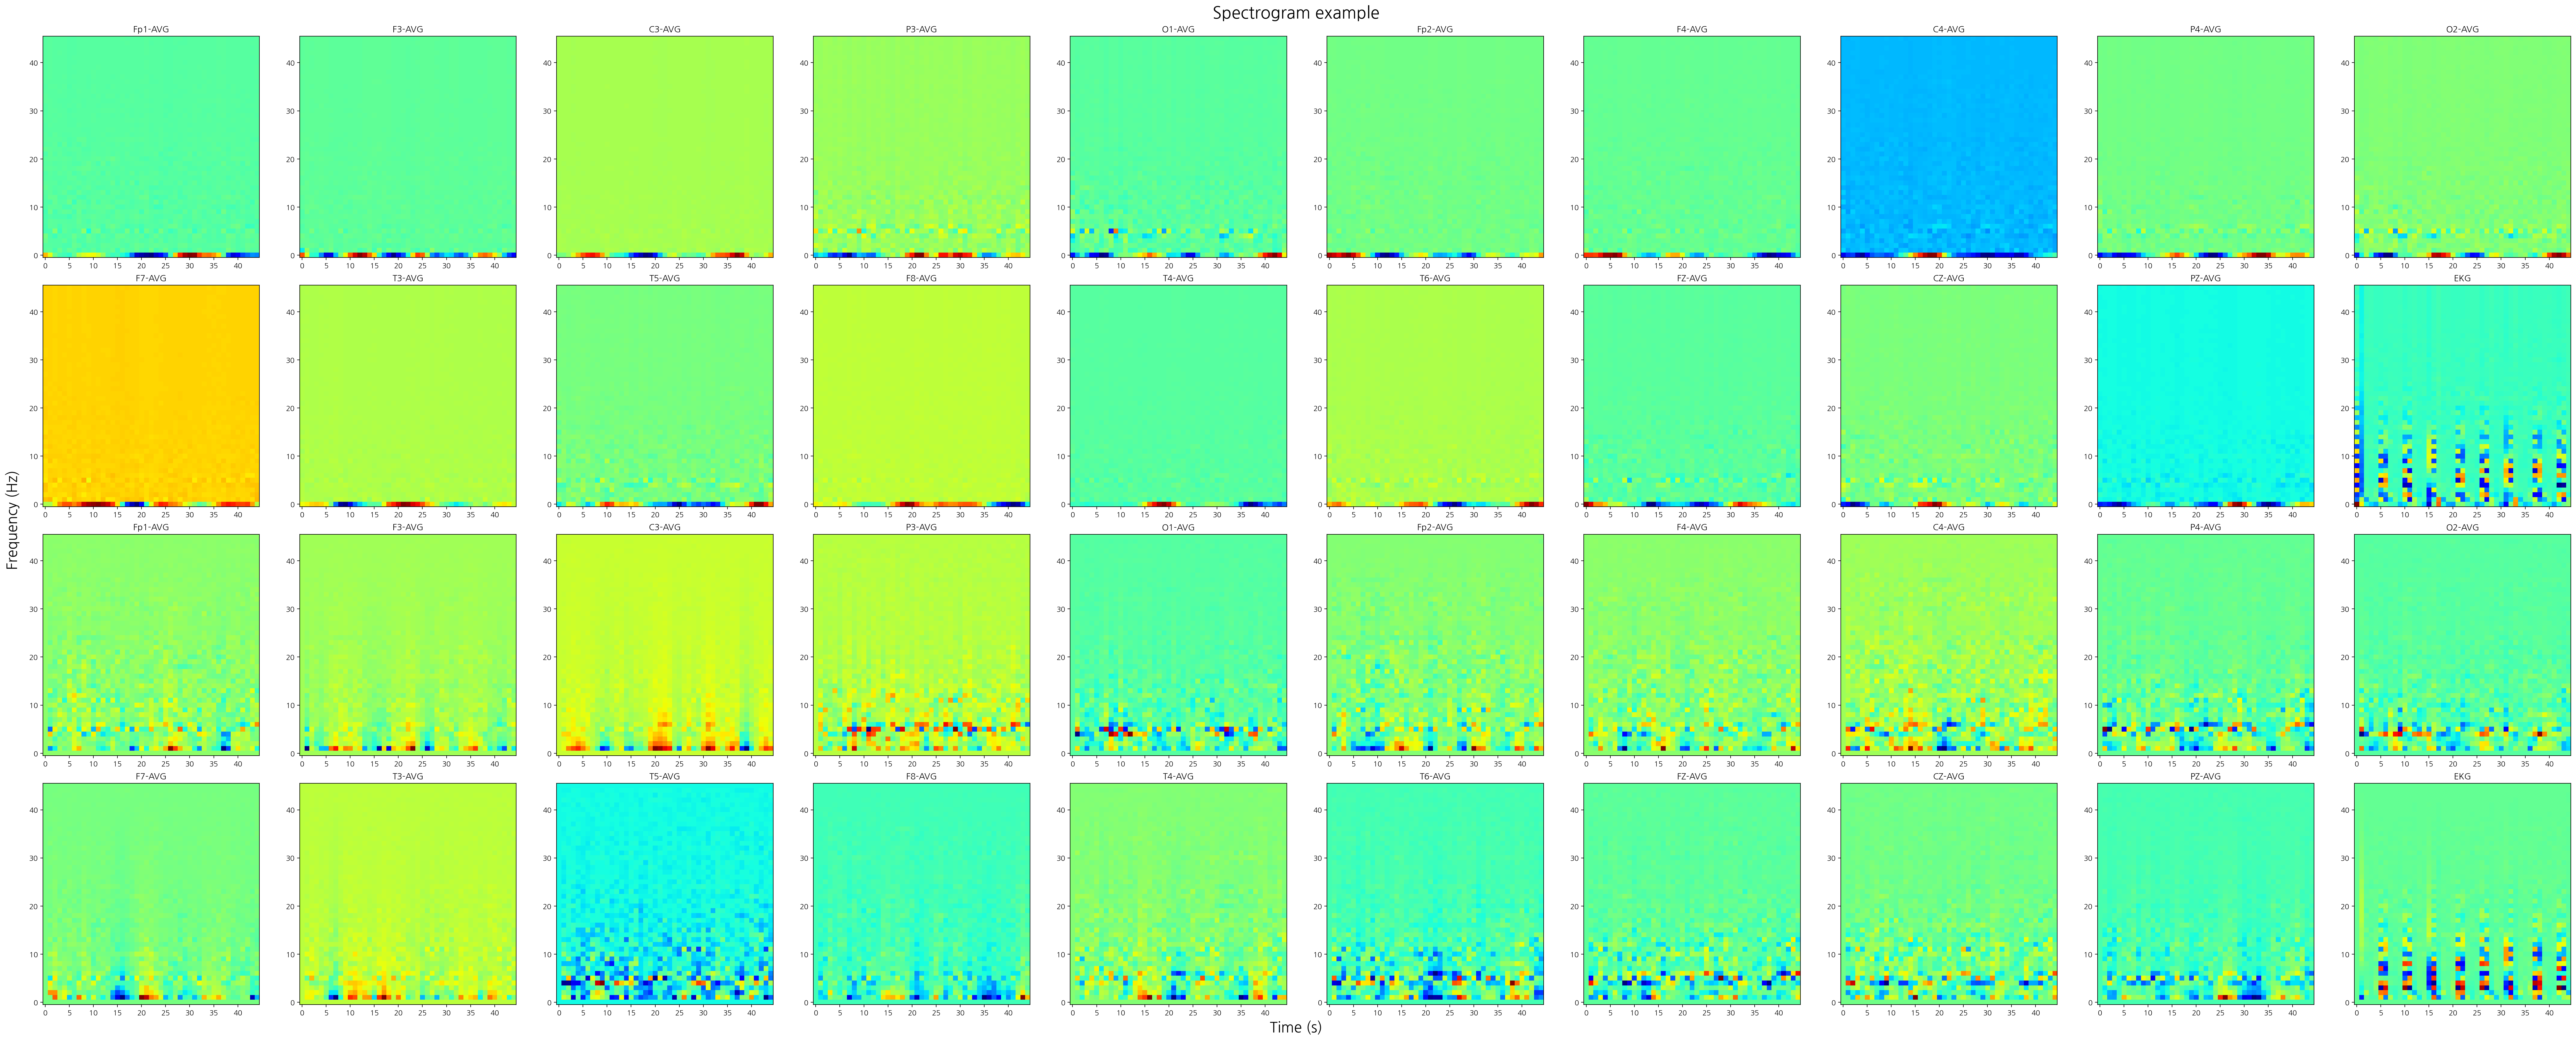

Done.


In [13]:
composed = transforms.Compose([EEGNormalizeAge(mean=age_mean, std=age_std),
                               EEGDropPhoticChannel(),
                               EEGRandomCrop(crop_length=200*60), # 1 minutes
                               EEGNormalizePerSignal(),
                               EEGToTensor(), 
                               EEGSpectrogram(n_fft=200, complex_mode='as_real', hop_length=200 // 2)])

train_dataset = EEGDataset(root_path, metadata_train, composed)
val_dataset = EEGDataset(root_path, metadata_val, composed)
test_dataset = EEGDataset(root_path, metadata_test, composed)

print(train_dataset[0]['signal'].shape)
print()
print('-' * 100)
print()

print(val_dataset[0]['signal'].shape)

print()
print('-' * 100)
print()

print(test_dataset[0]['signal'].shape)

print()
print('-' * 100)
print()

# visualization
signal_headers = ['Fp1-AVG', 'F3-AVG', 'C3-AVG', 'P3-AVG', 
                  'O1-AVG', 'Fp2-AVG', 'F4-AVG', 'C4-AVG', 
                  'P4-AVG', 'O2-AVG', 'F7-AVG', 'T3-AVG', 
                  'T5-AVG', 'F8-AVG', 'T4-AVG', 'T6-AVG', 
                  'FZ-AVG', 'CZ-AVG', 'PZ-AVG', 'EKG'] * 2

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

signal_f = train_dataset[0]['signal']
fig = plt.figure(num=1, clear=True, figsize=(50.0, 20.0), constrained_layout=True)

for k in range(signal_f.shape[0]):
    ax = fig.add_subplot(signal_f.shape[0] // 10, 10, k + 1)
    ax.imshow(signal_f[k], interpolation='nearest')
    ax.set_title(signal_headers[k], fontsize=12)
    ax.invert_yaxis()
    
fig.suptitle('Spectrogram example', fontsize=23)
fig.supxlabel('Time (s)', fontsize=20)
fig.supylabel('Frequency (Hz)', fontsize=20)
plt.show()
fig.clear()
plt.close(fig)
    
print('Done.')

#### Data loader test

In [ ]:
print('Current PyTorch device:', device)
if device.type == 'cuda':
    num_workers = 0 # A number other than 0 causes an error
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

for i_batch, sample_batched in enumerate(train_loader):
    sample_batched['signal'].to(device)
    sample_batched['age'].to(device)
    sample_batched['class_label'].to(device)
    
    print(i_batch, 
          sample_batched['signal'].shape, 
          sample_batched['age'].shape, 
          sample_batched['class_label'].shape, 
          len(sample_batched['metadata']))
    
    if i_batch > 3:
        break

#### Train, validation, test dataloaders

In [ ]:
train_loader = DataLoader(train_dataset, 
                          batch_size=32, 
                          shuffle=True, 
                          drop_last=True,
                          num_workers=num_workers, 
                          pin_memory=pin_memory,
                          collate_fn=eeg_collate_fn)

val_loader = DataLoader(val_dataset, 
                        batch_size=32, 
                        shuffle=False, 
                        drop_last=False,
                        num_workers=num_workers, 
                        pin_memory=pin_memory,
                        collate_fn=eeg_collate_fn)

test_loader = DataLoader(test_dataset, 
                         batch_size=32, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=num_workers, 
                         pin_memory=pin_memory,
                         collate_fn=eeg_collate_fn)

-----

## Some useful functions for training

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import ipynbname
nb_fname = ipynbname.name()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def visualize_network_tensorboard(model, name):
    # default `log_dir` is "runs" - we'll be more specific here
    writer = SummaryWriter('runs/' + nb_fname + '_' + name)

    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)

        # apply model on whole batch directly on device
        writer.add_graph(model, (x, age))
        output = model(x, age, print_shape=True)
        break
        
    writer.close()

In [ ]:
def train_one_epoch(model, optimizer, log_interval):
    # turn the models to training mode
    model.train()
    losses = []
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    train_confusion = np.zeros((C, C), dtype=np.int32)
    
    for batch_i, sample_batched in enumerate(train_loader):
        # pull up the batch data
        x = sample_batched['signal'].to(device)
        age = sample_batched['age'].to(device)
        target = sample_batched['class_label'].to(device)
        
        # apply model on whole batch directly on device
        output = model(x, age)

        # negative log-likelihood for a tensor of size (batch x n_output)
        pred = F.log_softmax(output, dim=1)
        loss = F.nll_loss(pred, target)
        
        # backprop and update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # record loss
        losses.append(loss.item())

        # train accuracy
        pred = pred.argmax(dim=-1)
        correct += pred.squeeze().eq(target).sum().item()
        total += pred.shape[0]
        
        # confusion matrix
        train_confusion += calculate_confusion_matrix(pred, target)

        # print training stats
        if log_interval is not None and (batch_i + 1) % log_interval == 0:
            print(f'- Iter {batch_i + 1:03d} / {len(train_loader):03d}, Loss: {loss.item():.06f}')
    
    train_accuracy = 100.0 * correct / total
    return (losses, train_accuracy, train_confusion)


def check_val_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
        
    C = len(class_label_to_type)
    val_confusion = np.zeros((C, C), dtype=np.int32)
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in val_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)

                # val accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # confusion matrix
                val_confusion += calculate_confusion_matrix(pred, target)
            
    val_accuracy = 100.0 * correct / total
    return (val_accuracy, val_confusion)

    
def check_test_accuracy(model, repeat=1):
    model.eval()
    correct, total = (0, 0)
    
    C = len(class_label_to_type)
    test_confusion = np.zeros((C, C), dtype=np.int32)
    
    test_debug = {data['metadata']['serial']: 
              {'GT': data['class_label'].item(), 
               'Acc': 0, 
               'Pred': [0] * C} for data in test_dataset}
    
    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in test_loader:
                # pull up the data
                x = sample_batched['signal'].to(device)
                age = sample_batched['age'].to(device)
                target = sample_batched['class_label'].to(device)

                # apply model on whole batch directly on device
                output = model(x, age)
                pred = F.log_softmax(output, dim=1)

                # test accuracy
                pred = pred.argmax(dim=-1)
                correct += pred.squeeze().eq(target).sum().item()
                total += pred.shape[0]

                # confusion matrix
                test_confusion += calculate_confusion_matrix(pred, target)

                # test debug
                for n in range(pred.shape[0]):
                    serial = sample_batched['metadata'][n]['serial']
                    test_debug[serial]['edfname'] = sample_batched['metadata'][n]['edfname']
                    test_debug[serial]['Pred'][pred[n].item()] += 1
                    acc = test_debug[serial]['Pred'][target[n].item()] / np.sum(test_debug[serial]['Pred']) * 100
                    test_debug[serial]['Acc'] = f'{acc:>6.02f}%'
                
    test_accuracy = 100.0 * correct / total
    return (test_accuracy, test_confusion, test_debug)


def calculate_confusion_matrix(pred, target):
    N = target.shape[0]
    C = len(class_label_to_type)
    confusion = np.zeros((C, C), dtype=np.int32)
    
    for i in range(N):
        r = target[i]
        c = pred[i]
        confusion[r, c] += 1
    return confusion

In [ ]:
def draw_loss_plot(loss_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(loss_history)
    
    ax.vlines(0, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)    
    for e in range(1, n_epoch + 1):
        
        if e % lr_schedule_step == 0:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='m', alpha=0.3)
        else:
            ax.vlines(e*len(train_loader) - 1, 0, 1, transform=ax.get_xaxis_transform(), colors='k', alpha=0.1)
    
    ax.set_title('Loss Plot')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Training Loss')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_accuracy_history(train_acc_history, val_acc_history):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    
    fig = plt.figure(num=1, clear=True, figsize=(15.0, 6.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_acc_history, 'r-', label='Train accuracy')
    ax.plot(val_acc_history, 'b-', label='Validation accuracy')
    ax.legend(loc='lower right')
    
    ax.set_title('Accuracy Plot during Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    
    plt.show()
    fig.clear()
    plt.close(fig)


def draw_confusion(confusion):
    C = len(class_label_to_type)
    
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic
    plt.rcParams['image.cmap'] = 'jet' # 'nipy_spectral'

    fig = plt.figure(num=1, clear=True, figsize=(5.0, 5.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(confusion, alpha=0.8)

    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(C))
    ax.set_xticklabels(class_label_to_type)
    ax.set_yticklabels(class_label_to_type)
    
    for r in range(C):
        for c in range(C):
            text = ax.text(c, r, confusion[r, c],
                           ha="center", va="center", color='k')
    
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground Truth')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()
    fig.clear()
    plt.close(fig)

In [ ]:
def learning_rate_search(model, min_log_lr, max_log_lr, trials, epochs):
    learning_rate_record = []
    for t in tqdm(range(trials)):
        log_lr = np.random.uniform(min_log_lr, max_log_lr)
        lr = 10 ** log_lr
        
        model.reset_weights()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0001)

        for e in range(epochs):
            _, train_accuracy, _ = train_one_epoch(model, optimizer, log_interval=None)
        
        # Train accuracy for the final epoch is stored
        learning_rate_record.append((log_lr, train_accuracy))
    
    return learning_rate_record


def draw_learning_rate_record(learning_rate_record):
    plt.style.use('default') # default, ggplot, fivethirtyeight, classic

    fig = plt.figure(num=1, clear=True, figsize=(8.0, 8.0), constrained_layout=True)
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_title('Learning Rate Search')
    ax.set_xlabel('Learning rate in log-scale')
    ax.set_ylabel('Train accuracy')
    
    for log_lr, val_accuracy in learning_rate_record:
        ax.scatter(log_lr, val_accuracy, c='r',
                   alpha=0.5, edgecolors='none')
    
    plt.show()
    fig.clear()
    plt.close(fig)

-----

## Train 2D CNN models

#### 2D CNN: ResNet-like model

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    
class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [1]:
class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        n_input: int = 40,
        n_output: int = 64,
        n_start: int = 3,
        n_fc: int = 3,
        use_age: bool = True,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = n_start
        self.use_age = use_age
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(n_input, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        fc_layers = []        
        n_current = 512 * block.expansion

        if self.use_age:
            n_current = n_current + 1
        
        for l in range(n_fc):
            layer = nn.Sequential(nn.Linear(n_current, n_current // 2, bias=False),
                                  nn.Dropout(p=0.1),
                                  nn.BatchNorm1d(n_current // 2), 
                                  nn.ReLU())
            n_current = n_current // 2
            fc_layers.append(layer)
        fc_layers.append(nn.Linear(n_current, n_output))
        self.fc_stage = nn.Sequential(*fc_layers)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]
                    
    def reset_weights(self):
        for m in self.modules():
            if hasattr(m, 'reset_parameters'):
                m.reset_parameters()
                
    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: torch.Tensor, age: torch.Tensor, print_shape: bool = False) -> torch.Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if print_shape:
            print('Shape right before squeezing:', x.shape)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if self.use_age:
            x = torch.cat((x, age.reshape(-1, 1)), dim=1)
        x = self.fc_stage(x)

        return x

    def forward(self, x: torch.Tensor, age: torch.Tensor, print_shape: bool = False) -> torch.Tensor:
        return self._forward_impl(x, age, print_shape)

NameError: name 'nn' is not defined

In [ ]:
def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

#### ResNet-18

In [ ]:
model = resnet18(n_fc=3, 
                 n_input=40, 
                 n_output=3, 
                 n_start=64, 
                 use_age=True)
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'ResNet-18')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

In [ ]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=1)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -3.5734690154712436
print('best_log_lr:', best_log_lr)

In [ ]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)

#### ResNet-50

In [ ]:
model = resnet50(n_fc=3, 
                 n_input=40, 
                 n_output=3, 
                 n_start=64, 
                 use_age=True)
model = model.to(device, dtype=torch.float32)
print(model)
print()

# tensorboard visualization
visualize_network_tensorboard(model, 'ResNet-50')

# number of parameters
n = count_parameters(model)
print(f'The Number of parameters of the model: {n:,}')

In [ ]:
# record = learning_rate_search(model, 
#                               min_log_lr=-4.5, 
#                               max_log_lr=-1.4, 
#                               trials=500, 
#                               epochs=1)
# draw_learning_rate_record(record)
# best_log_lr = record[np.argmax(np.array([v for lr, v in record]))][0]

best_log_lr = -2.369827466077312
print('best_log_lr:', best_log_lr)

In [ ]:
# reduce the learning after [lr_schedule_step] epochs by a factor of 10
n_epoch = 500
lr_schedule_step = 200
log_interval = len(train_loader) // 2

loss_history = []
train_acc_history = []
val_acc_history = []

model.reset_weights()
optimizer = optim.AdamW(model.parameters(), lr=10 ** best_log_lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_schedule_step, gamma=0.1)

print(f'{"*"*40} Training Starts {"*"*40}')

for epoch in tqdm(range(1, n_epoch + 1)):
    print(f'{"-"*30} Epoch {epoch:03d} / {n_epoch:03d}, Learning rate: {optimizer.param_groups[-1]["lr"]:.2e} {"-"*30}')
    
    # train
    loss, train_accuracy, train_confusion = train_one_epoch(model, optimizer, log_interval)
    loss_history.extend(loss)
    train_acc_history.append(train_accuracy)
    
    # validation
    val_accuracy, val_confusion = check_val_accuracy(model)
    val_acc_history.append(val_accuracy)
    
    # learning rate schedule
    scheduler.step()
    
    print()
    print(f'* Train accuracy / confusion: {train_accuracy:.2f}% / {train_confusion.tolist()}, ')
    print(f'* Val   accuracy / confusion: {val_accuracy:.2f}% / {val_confusion.tolist()}')
    print()
    
# test
test_accuracy, test_confusion, test_debug = check_test_accuracy(model, repeat=30)

print(f'{"*"*40} Training Ends {"*"*40}')
print(f'- Test accuracy: {test_accuracy:.2f}%')
print()
print('- Confusion matrix:\n', test_confusion)
print()

# draw the training loss plot
draw_loss_plot(loss_history)
draw_accuracy_history(train_acc_history, val_acc_history)

# draw the confusion matrix
draw_confusion(test_confusion)

In [ ]:
print('- Debug table:')
pprint.pp(test_debug, indent=2, width=100)